In [1]:
# import statements
import utils
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Loading data

# Fake data
articles = np.asarray([
    ["Donald Trump buys a dog", "Donald Trump recently was found buying a dog"],
    ["President Trump gets a corgie", "The White House welcomes a new furry friend, and its name is Evan!"],
    ["U.S. Presidential Paws", "You won't believe the new dog that Donald and the fam just got!"],
    ["Biden sells his old car", "President Biden just announced that he is selling is '96 Civic"],
    ["President Biden to sell car", "Biden announced via Twitter that he will indeed be selling his car"],
    ["Biden getting that car cash", "Biden is about to cash out once he sells that junker civic!"]
])

In [3]:
# Vectorizing 
# Combining headlines and bodies
a = [x[0] + ': ' + x[1] for x in articles]
# Generating model 
roberta = SentenceTransformer('stsb-roberta-base')
v = utils.encode(a, roberta)

In [4]:
# Dimensionality reduction
pca = PCA(n_components = 5)
components = pca.fit_transform(v)
print('Percent variance explained: {:.2f}'.format(sum(pca.explained_variance_ratio_)))

Percent variance explained: 1.00


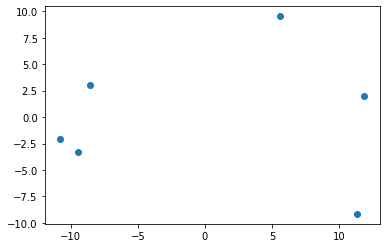

In [5]:
# Visualizing PCA
plt.scatter(components[:,0], components[:,1])

In [6]:
# Clustering 
K = 2
clusters = KMeans(n_clusters=K, random_state=0).fit(components)

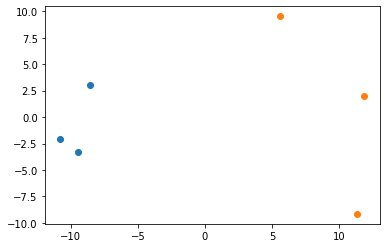

In [7]:
# Visualizing Clusters
for i in range(K):
    labels = clusters.labels_ == i
    plt.scatter(components[labels,0], components[labels,1])

In [8]:
# Printing out different clusters
for i in range(K):
    labels = clusters.labels_ == i
    print('Cluster #:', i)
    for j, article in enumerate(articles[labels]):
        print(j, article)

Cluster #: 0
0 ['Biden sells his old car'
 "President Biden just announced that he is selling is '96 Civic"]
1 ['President Biden to sell car'
 'Biden announced via Twitter that he will indeed be selling his car']
2 ['Biden getting that car cash'
 'Biden is about to cash out once he sells that junker civic!']
Cluster #: 1
0 ['Donald Trump buys a dog' 'Donald Trump recently was found buying a dog']
1 ['President Trump gets a corgie'
 'The White House welcomes a new furry friend, and its name is Evan!']
2 ['U.S. Presidential Paws'
 "You won't believe the new dog that Donald and the fam just got!"]


In [29]:
# Creating the graph
import networkx as nx

G = nx.Graph()

In [63]:
G.add_nodes_from(['dog','cat'])
G.add_edge('dog','cat')
G.add_edge(1,2)
G.clear()

In [72]:
for art, artv in zip(articles, v):
    root = (art, artv)
    rel = [x for x,y in zip(articles,v) if utils.doc_sim(root[1], y) > .01]

    for art in rel:
        print(root[0][0], art[0])
        G.add_edge(root[0][0], art[0])

Donald Trump buys a dog Donald Trump buys a dog
Donald Trump buys a dog President Trump gets a corgie
Donald Trump buys a dog U.S. Presidential Paws
Donald Trump buys a dog Biden sells his old car
Donald Trump buys a dog President Biden to sell car
Donald Trump buys a dog Biden getting that car cash
President Trump gets a corgie Donald Trump buys a dog
President Trump gets a corgie President Trump gets a corgie
President Trump gets a corgie U.S. Presidential Paws
President Trump gets a corgie Biden sells his old car
President Trump gets a corgie President Biden to sell car
President Trump gets a corgie Biden getting that car cash
U.S. Presidential Paws Donald Trump buys a dog
U.S. Presidential Paws President Trump gets a corgie
U.S. Presidential Paws U.S. Presidential Paws
U.S. Presidential Paws Biden sells his old car
U.S. Presidential Paws President Biden to sell car
U.S. Presidential Paws Biden getting that car cash
Biden sells his old car Donald Trump buys a dog
Biden sells his old

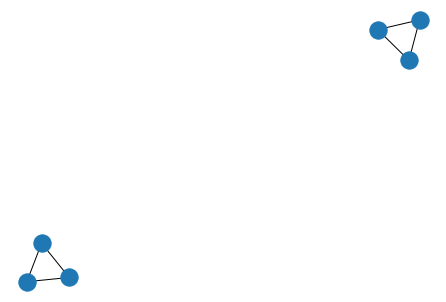

In [68]:
nx.draw(G)

In [ ]:
G.